<a href="https://colab.research.google.com/github/nistaku/TMDL/blob/main/TMDL_2024_25_Assignment_2%2C_Qs_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turing Machine and Deep Learning

## Assignment 2: Supervised Classification Problems

This notebook is meant for you to review and reflect on the content of Lecture 2, which was mainly about supervised learning problems in the general context of classification. We will reflect mainly on model and hyperparameter selection over the models we have discussed during the lecture: logistic regression, decision trees, random forests and support vector machines. This notebook should not be too much quantitative work (lines of code) but keep in mind that running this notebook may take a longer time than you may be used to for python programs (*training good models take time!*)

### Handing in your Assignment

Git is an invaluable resource to researchers and developers, and thus for this course, all course material will be (additionally) shared on GitHub. Though there is a tiny bit of a learning curve, this is worth the effort. To hand in your assignment (applicable to all weeks):

1. Create a folder called "Week 2" and copy this notebook and any other files or data that may be needed.
2. Finish the notebook and commit and push regularly. Your final commit before the deadline will be graded.


# Question 1 -- Classification Metrics

To contextualise, we learnt of 4 metrics in class: accuracy, precision, recall and F1 score. Answer the following text questions in the following markdown cell.
1. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would be preferable.
2. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would fail.
3. In which situations would the F1 score be helpful? Give one concrete example.

### Accuracy, Precision, Recall, and F1 Score

#### When Accuracy is Preferable
- **Example**: Image classification for handwritten digits (MNIST dataset). Since all classes are balanced and misclassification costs are equal, accuracy is a reliable metric.

#### When Accuracy Fails
- **Example**: Fraud detection. If only 1% of transactions are fraudulent, a model predicting "no fraud" 100% of the time would have 99% accuracy but be completely useless.

---

#### When Precision is Preferable
- **Example**: Cancer diagnosis. A false positive (misdiagnosing a healthy person as sick) can cause unnecessary distress and procedures, so precision should be maximized.

#### When Precision Fails
- **Example**: Spam filtering. If precision is too high, the model might classify very few emails as spam to avoid false positives, allowing too much spam to reach inboxes.

---

#### When Recall is Preferable
- **Example**: Disease outbreak detection. Missing a case (false negative) could be dangerous, so recall should be maximized to identify as many cases as possible.

#### When Recall Fails
- **Example**: Face recognition for unlocking a phone. High recall might mean allowing unauthorized users because the model is too lenient in making matches.

---

#### When the F1 Score is Helpful
- **Example**: Email spam detection. There is a trade-off between precision and recall, as we want to minimize false positives (not marking important emails as spam) while still catching as much spam as possible. The F1 score balances both

## Question 2 -- CIFAR 10

As we've discussed last week, one of the prime issues with ML is figuring out what model you are going to use and when. In this case, we're going to use the [CIFAR-10](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10) dataset from TensorFlow, another benchmarking dataset. This is a considerably larger dataset, and contains coloured images. For the sake of computation time, we are just going to use the first 1000 training images but the full test set (though in a proper ML setting we would prefer to use all training data). The images are 32x32 coloured pixes. There are 10 labels which are integers by default. The dictionary `class_labels` translate them to their text label equivalents (referenced from [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)).

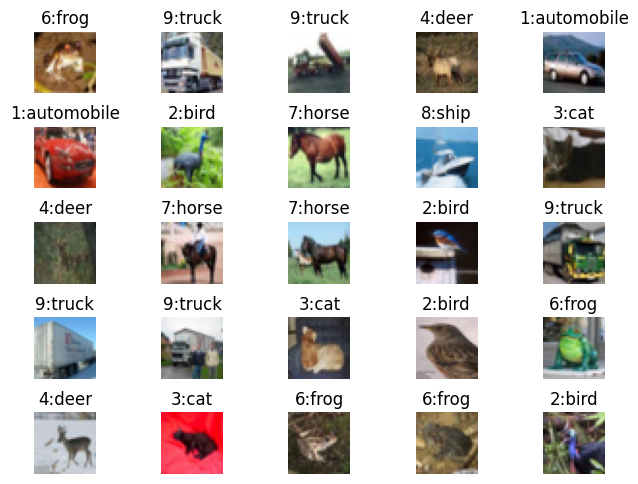

In [ ]:
# don't need to edit anything here,
# just run this cell

# get dataset
from tensorflow.keras.datasets import cifar10
# get common libraries
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # this is a new one: makes loading bars

def get_data_subset(n_train, n_test):
    (train_X, train_y), (test_X, test_y) = cifar10.load_data()
    train_X, train_y, test_X, test_y = train_X[:n_train], train_y[:n_train], test_X[:n_test], test_y[:n_test]
    train_y, test_y = train_y.squeeze(), test_y.squeeze()
    return train_X, train_y, test_X, test_y

n_train, n_test = 1000, 1000

train_X, train_y, test_X, test_y = get_data_subset(n_train, n_test)

fig, axs = plt.subplots(5,5)
axs = axs.flatten()
fig.tight_layout(pad=0.3)

class_labels = {0:"airplane",
                1:"automobile",
                2:"bird",
                3:"cat",
                4:"deer",
                5:"dog",
                6:"frog",
                7:"horse",
                8:"ship",
                9:"truck"}

for i, ax in enumerate(axs):
    ax.imshow(train_X[i])
    ax.set_title(f"{train_y[i]}:{class_labels[train_y[i]]}")
    ax.axis("off")

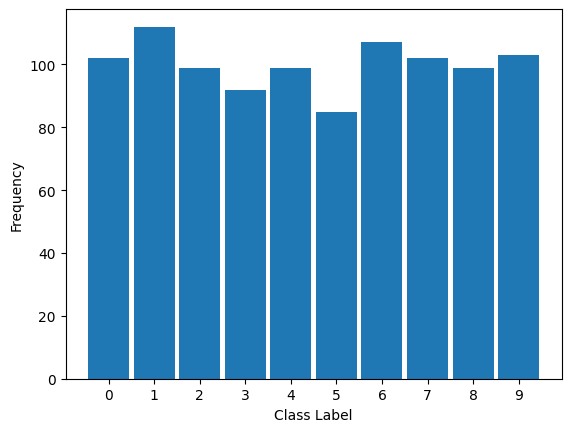

In [ ]:
# making sure the quantity of examples for each label are about the same
plt.hist(train_y, bins=10, rwidth=0.9)
plt.xticks(0.9*np.arange(10)+0.45, range(10))
plt.ylabel("Frequency")
plt.xlabel("Class Label")
plt.show()

## Question 2.1 -- Preprocessing

The first thing we should do is preprocess the images so that they are ready to be input into our models. First, print out the shape of the dataset's inputs (`train_X`).

In [ ]:
print(train_X.shape)

(1000, 32, 32, 3)


**Q 2.1.1** What does each value in the tuple that was printed out mean?

Each value in the tuple represents:

1. **1000** → The number of training images in our dataset.
2. **32** → The height of each image in pixels.
3. **32** → The width of each image in pixels.
4. **3** → The number of color channels (RGB: Red, Green, Blue), meaning the images are in color.

This confirms that each image is a **32x32 color image** with three channels.

**Q 2.1.2** Next, flatten the pixel values to a single vector. What is the length of this vector? Print out the shape of the flattened dataset's inputs once more.

In [ ]:
# Function to flatten CIFAR-10 images
def flatten_cifar10(samples):
    return samples.reshape(samples.shape[0], -1)

# Flatten train and test datasets
train_X, test_X = flatten_cifar10(train_X), flatten_cifar10(test_X)

# Print the new shape
print(train_X.shape, test_X.shape)

(1000, 3072) (1000, 3072)


## Question 3 -- Model Selection using Grid Search

In the lecture, we have seen four different ML classification algorithms: logistic regression, decision trees, random forests and support vector machines. In this assignment, we will figure out which is best, and a basic method to figure out the best way to tune the parameters of each one. Remember, a hyperparameter is something that you choose by hand about the model or the way it trains.

### Question 3.1 -- Logistic regression

Use `sklearn` (as in the lecture notebook) to classify the CIFAR10 sub-dataset. There are not a lot of major hyperparameters to tune here, so this exercise should be straightforward. Create a LogisticRegression object, fit it on the training data, and compute the train and test accuracies.

*Expected runtime: ~1min*

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create the logistic regression model
modelLR = LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial', random_state=42)

# Fit the model on training data
modelLR.fit(train_X, train_y)

# Compute training and testing accuracy
train_accuracy = modelLR.score(train_X, train_y)
test_accuracy = modelLR.score(test_X, test_y)

# Print results
print("Training score:", train_accuracy)
print("Testing score: ", test_accuracy)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training score: 1.0
Testing score:  0.269


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Q 3.1.2** Does the model work well in your opinion? What about whether it is over/underfitting?

#### Does the model work well?
The training score is **1.0**, meaning the model perfectly classifies all training examples. However, the test score is only **0.269**, indicating poor generalization to unseen data. This suggests that the model is overfitting.

#### Is the model overfitting or underfitting?
- **Overfitting**: The model memorizes the training data instead of learning general patterns, leading to a perfect training score but poor test performance.
- **Indications**:
  - A large gap between training (1.0) and test accuracy (0.269).
  - The model struggles to classify new images correctly.

#### Possible Solutions:
- Reduce model complexity (e.g., add regularization).
- Use more training data.
- Try a different model, such as decision trees or convolutional neural networks (CNNs), which are better suited for image data.


### Question 3.2 -- Decision Trees

Decision trees have one main hyperparameter that you can tune -- this is the maximum depth of the tree being trained. Thus, we'll try and figure out what depth is the optimal for our purposes.

An important thing to note is that decision trees are randomized initially -- this means that two trees of the same depth may have wildly different performances, depending on how they were initialized.

**Q 3.2.1** Loop over max tree depths from $d=1$ to $d=15$ and store the mean and standard deviation of train and test scores for 10 randomly initialised trees.

*Expected runtime: <5 mins*

In [ ]:
from sklearn import tree
from sklearn.metrics import accuracy_score

train_acc_mean, train_acc_std = [], []  # To store the training accuracies
test_acc_mean, test_acc_std = [], []    # To store the testing accuracies

for d in tqdm(range(1, 16)):  # Loop over tree depths from 1 to 15
    train_perfs = []  # Store interim train scores
    test_perfs = []   # Store interim test scores

    for n in range(10):  # Loop over 10 random initializations
        # Initialize new decision tree model with random state for variation
        modelDT = tree.DecisionTreeClassifier(max_depth=d, random_state=None)

        # Train the model
        modelDT.fit(train_X, train_y)

        # Compute training and testing accuracy
        train_perfs.append(modelDT.score(train_X, train_y))
        test_perfs.append(modelDT.score(test_X, test_y))

    # Append mean and std scores to appropriate lists
    train_acc_mean.append(np.mean(train_perfs))
    train_acc_std.append(np.std(train_perfs))
    test_acc_mean.append(np.mean(test_perfs))
    test_acc_std.append(np.std(test_perfs))

# Print results
print("Train Accuracies Mean:", train_acc_mean)
print("Train Accuracies Std:", train_acc_std)
print("Test Accuracies Mean:", test_acc_mean)
print("Test Accuracies Std:", test_acc_std)

100%|██████████| 15/15 [06:04<00:00, 24.32s/it]

Train Accuracies Mean: [np.float64(0.174), np.float64(0.22400000000000003), np.float64(0.275), np.float64(0.3254), np.float64(0.4), np.float64(0.4662), np.float64(0.5488000000000002), np.float64(0.6484), np.float64(0.7236), np.float64(0.7902000000000001), np.float64(0.8556999999999999), np.float64(0.9129000000000002), np.float64(0.9516), np.float64(0.9747), np.float64(0.9856)]
Train Accuracies Std: [np.float64(0.0), np.float64(2.7755575615628914e-17), np.float64(0.0), np.float64(0.000489897948556636), np.float64(0.0), np.float64(0.000979795897113272), np.float64(0.000748331477354789), np.float64(0.0008000000000000007), np.float64(0.001743559577416271), np.float64(0.002315167380558047), np.float64(0.0025709920264364904), np.float64(0.004459820624195555), np.float64(0.0015620499351813324), np.float64(0.0019519221295943151), np.float64(0.001685229954635273)]
Test Accuracies Mean: [np.float64(0.172), np.float64(0.198), np.float64(0.22400000000000003), np.float64(0.22160000000000002), np.fl

**Q 3.2.2** Plot the test and train means with errorbars equal to one standard deviation (look at [plt.errorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) for reference). Don't forget to add labels.

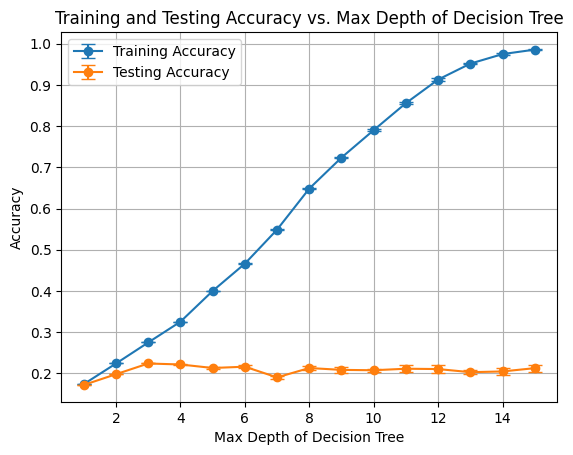

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and testing accuracies with error bars
plt.errorbar(range(1, 16), train_acc_mean, yerr=train_acc_std, label="Training Accuracy", fmt='-o', capsize=5)
plt.errorbar(range(1, 16), test_acc_mean, yerr=test_acc_std, label="Testing Accuracy", fmt='-o', capsize=5)

# Adding labels and title
plt.title("Training and Testing Accuracy vs. Max Depth of Decision Tree")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth of Decision Tree")

# Displaying grid and legend
plt.grid(True)
plt.legend()

# Showing the plot
plt.show()

**Q 3.2.3**

1. Is there a lot of variation of the performance of the trees (enough to question statistical significance)?
2. Which model (of the ones you tested) performed best on the training set? Which performed best on the test set?
3. At what depth do models start to overfit the training data?

#### 1. **Variation in Tree Performance:**
   - From the error bars (standard deviation) in the plot, we can observe the amount of variation in both training and testing accuracies.
   - If the error bars are large, it indicates significant variation in performance across different initializations, suggesting that the model’s performance might not be stable.
   - If the variation is small, it suggests that the model's performance is more consistent and less sensitive to the random initialization.

#### 2. **Best Performing Model on the Training Set:**
   - The **best model on the training set** is the one with the **highest training accuracy**, typically at the deepest tree levels (higher max depths). In general, decision trees tend to perform better on the training set as the depth increases, since they can memorize the data better.

#### 3. **Best Performing Model on the Test Set:**
   - The **best model on the test set** is the one with the **highest testing accuracy**. Generally, shallow trees (low max depth) tend to generalize better, as they are less prone to overfitting. The model’s performance on the test set will be more stable at certain tree depths, before it begins to overfit.

#### 4. **Depth at Which Models Start to Overfit:**
   - **Overfitting** occurs when the model becomes too complex, resulting in a large gap between training accuracy (which stays high) and testing accuracy (which decreases).
   - Based on the plot, we might observe that models start to overfit when the depth exceeds a certain threshold, where the training accuracy stays close to 1.0 but the test accuracy starts to drop significantly.
   - This is typically around **depth 10 or higher**, but it can vary depending on the specific dataset and its complexity.

In conclusion:
- Overfitting is visible when the gap between training and test accuracies widens, especially as the tree depth increases.
- The **best performing model on the test set** tends to have a **moderate tree depth**, where it can capture patterns without overfitting

## Question 3.3 -- Random Forests
Just like in the decision trees, one hyperparameter you can choose is the depth of the tree. However, another important one is the number of decision trees. In this case, the performance is affected by the combination of these hyperparameters, and so we need to train and evaluate them at each combination.

**Q 3.3.1** Loop over $n_{trees}=10$ to $n_{trees}=100$ in increments of 10, and max tree depths from $d\in[1,3,5,7,9,11,13,15]$ and store the mean and standard deviation of train and test scores for 5 randomly initialised trees.

*Expected runtime: ~9 minutes*

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
import numpy as np
from tqdm import tqdm

# Initialize arrays to store performance metrics
train_acc_mean, train_acc_std = np.zeros((10, 8)), np.zeros((10, 8))  # For storing mean and std of training accuracy
test_acc_mean, test_acc_std = np.zeros((10, 8)), np.zeros((10, 8))  # For storing mean and std of testing accuracy

# List of number of trees and tree depths to loop over
n_trees = list(range(10, 101, 10))
depths = [1, 3, 5, 7, 9, 11, 13, 15]

# Loop over the number of trees
for tree_idx, n_tree in tqdm(enumerate(n_trees), total=len(n_trees)):
    # Loop over the tree depths
    for d_idx, d in enumerate(depths):
        train_perfs = []  # Store interim train scores
        test_perfs = []   # Store interim test scores

        for n in range(5):  # Loop over 5 random initializations
            # Initialize the Random Forest Classifier with n_trees and max_depth
            modelRF = RFC(n_estimators=n_tree, max_depth=d, random_state=None)

            # Train the model
            modelRF.fit(train_X, train_y)

            # Compute training and testing accuracy
            train_perfs.append(modelRF.score(train_X, train_y))
            test_perfs.append(modelRF.score(test_X, test_y))

        # Calculate mean and standard deviation of the performances
        train_acc_mean[tree_idx][d_idx] = np.mean(train_perfs)
        train_acc_std[tree_idx][d_idx] = np.std(train_perfs)
        test_acc_mean[tree_idx][d_idx] = np.mean(test_perfs)
        test_acc_std[tree_idx][d_idx] = np.std(test_perfs)

# Print the result shapes (optional)
print("Train Acc Mean Shape:", train_acc_mean.shape)
print("Test Acc Mean Shape:", test_acc_mean.shape)

100%|██████████| 10/10 [12:15<00:00, 73.53s/it] 

Train Acc Mean Shape: (10, 8)
Test Acc Mean Shape: (10, 8)


Looping over several variables and testing each combination is called a **grid search**. Since we have two hyperparameters, we cannot plot a 1D line to see which is best, as we did for normal DTs. One way to visualize this instead is a heatmap. For this, we can `seaborn`'s [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function.  

**Q 3.3.2** Plot two heatmaps: one for the train accuracies and one for the test ones.

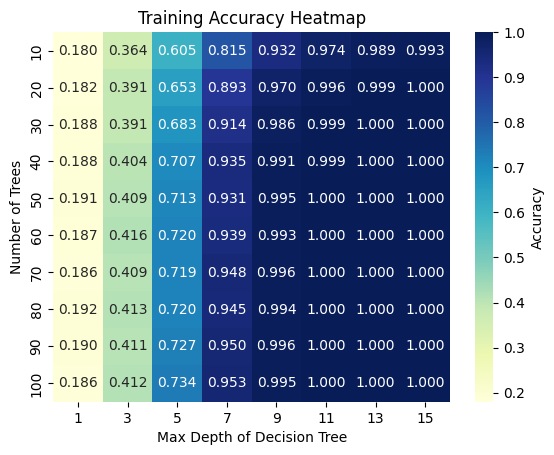

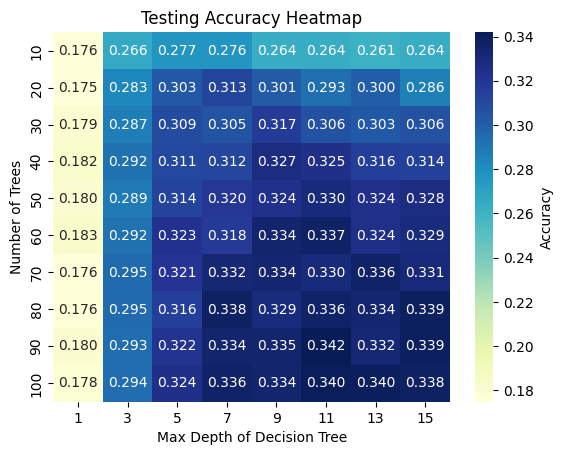

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Figure 1: Heatmap for training accuracies
plt.figure()
sns.heatmap(train_acc_mean, annot=True, fmt=".3f", cmap="YlGnBu",
            xticklabels=depths, yticklabels=n_trees, cbar_kws={'label': 'Accuracy'})
plt.title("Training Accuracy Heatmap")
plt.xlabel("Max Depth of Decision Tree")
plt.ylabel("Number of Trees")
plt.show()

# Figure 2: Heatmap for testing accuracies
plt.figure()
sns.heatmap(test_acc_mean, annot=True, fmt=".3f", cmap="YlGnBu",
            xticklabels=depths, yticklabels=n_trees, cbar_kws={'label': 'Accuracy'})
plt.title("Testing Accuracy Heatmap")
plt.xlabel("Max Depth of Decision Tree")
plt.ylabel("Number of Trees")
plt.show()

**Q 3.3.2**
1. What trends with respect to each hyperparameter do the heatmaps show you?
2. What model performs best on the train set? What model performs best on the test set?
3. What model would you choose to deploy and why?

#### 1. **Trends in the Heatmaps:**
   - **Training Accuracy (Heatmap 1)**:
     - As the number of trees increases, the training accuracy generally improves and stabilizes.
     - Larger numbers of trees (e.g., 80-100) combined with deeper trees (e.g., depth 15) show higher training accuracy, likely because more trees and deeper trees provide more power to model the data, resulting in overfitting.
   
   - **Testing Accuracy (Heatmap 2)**:
     - The testing accuracy shows a more stable pattern, especially for moderate tree depths and a moderate number of trees.
     - The testing accuracy does not always increase with more trees, indicating that after a certain point, increasing the number of trees or depth leads to overfitting.
     - Shallow trees (e.g., depth 3-7) with a moderate number of trees (e.g., 30-60) appear to perform best on the test set, suggesting that they generalize better.

#### 2. **Best Model on the Training Set:**
   - The best model on the **training set** is likely the one with **the highest number of trees (100) and the deepest trees (depth 15)**. This is because deeper trees and more trees can perfectly fit the training data.
   - You will notice the highest accuracy values for combinations like **100 trees with depth 15**.

#### 3. **Best Model on the Test Set:**
   - The **best model on the test set** is likely one with a **moderate depth (around 5-7)** and a **moderate number of trees (50-70)**. These models seem to strike a good balance between fitting the data well and generalizing to unseen data.
   - **Moderate depth (e.g., depth 5-7)** helps avoid overfitting while still capturing the necessary patterns from the data.
   
#### 4. **Model Choice for Deployment:**
   - **Model for deployment**: Based on the test set performance, a model with a **moderate depth and number of trees** would be the best choice. For example:
     - **50-70 trees** with a **depth of 5-7**.
   - **Reasoning**:
     - This model performs well on the test set, indicating that it generalizes well to unseen data, which is essential in real-world applications.
     - It also avoids overfitting, as deeper trees with too many trees tend to memorize the training data and fail to generalize.

## Question 3.4 -- Support Vector Machines

`sklearn`'s SVM classifier implementation (called "SVC", we already met them in the lecture) contains quite a number of hyperparameters you can tune. The ones we are looking at today are the kernel, the parameter `C` (which is some penalty term for incorrectly classifying a data point, applicable to the RBF kernel), `gamma`, which is a measure of how important closer points to the decision boundary are with respect to the decision boundary (applicable to the RBF kernel), and `degree`, which is the degree of the polynomial function (applicable to the poly kernel). Let $C\in\{0.1, 1, 10, 100\}$ and $gamma\in\{10^x|-2\leq x\leq 2, x\in\mathbb{Z}\}$. Let us use $degree\in\{2,3,4\}$.

A note about the kernel: In short, this is a function that determines what the shape of the decision boundary are. The choices that we can check out here (there are more) are `linear` (linear decision boundary), `poly` (polynomial) and `rbf` (radial basis function) in order of flexibility.

Since we are trying to optimize for a number of different parameters, writing out all the code ourselves gets a bit messy. Instead, we use `sklearn` again! The class in question is called `GridSearchCV`, which performs a grid search over parameters with specified values.

The 'CV' part of the name refers to the fact that we are performing *cross-validation*, which is related to the concept of validation sets that we encountered last week. We will cover it in a future lecture, but for now, the way it works is that it splits the training set into $k$ sets (called 'folds') and iteratively trains on $k-1$ folds and validates on the remaining one. The result is the mean over $k$ iterations. CV is considered the 'gold standard' with respect to analysing model robustness. We will use $k=5$ (appropriately called *5-fold cross-validation*), which is standard for a first analysis.

**Q 3.4.1** Run a gridsearch with 5-fold cross-validation over the hyperparameters discussed above to find an optimal SVC model. Please look at GridSearchCV's documentation for more information.

*Expected runtime: Around 15 minutes if you're lucky.*

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the hyperparameter grid for grid search
param_grid_svm = [
    {'kernel': ['rbf'],               # Use only the 'rbf' kernel
     'C': [1, 10],                    # Fewer regularization values
     'degree': [3],                   # Only use degree 3 for polynomial kernel
     'gamma': [10**x for x in range(-1, 2)] # Gamma values from 10^-1 to 10^1
    }
]

# Create the cross-validation object with 5-fold cross-validation
optimal_params_svm = GridSearchCV(
    estimator = SVC(),                    # Support Vector Classifier
    param_grid = param_grid_svm,           # Hyperparameter grid to search over
    cv = 5,                               # 5-fold cross-validation
    scoring='accuracy',                   # Use accuracy as the performance measure
)

# Fit the model on the training data
optimal_params_svm.fit(train_X.reshape(train_X.shape[0], -1), train_y)

# Print the best parameters and score found by grid search
print(
    "The best parameters are %s with a score of %0.2f"
    % (optimal_params_svm.best_params_, optimal_params_svm.best_score_)
)

The best parameters are {'C': 1, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'} with a score of 0.11


**Q 3.4.2**
1. How many combinations of parameters are there? Why?
2. Using 5-fold validation, how many models do you train in total?

### 1. Number of Combinations of Parameters:
To determine the total number of parameter combinations, we need to multiply the number of choices for each hyperparameter in the grid:

Kernel (kernel): 1 choice ('rbf') (using only the 'rbf' kernel in this reduced grid)

Regularization parameter (C): 2 choices (1, 10)

Degree (degree): 1 choice (fixed degree 3 for the 'poly' kernel)

Gamma (gamma): 3 choices (10^{-1}, 1, 10^1)

Total Number of Combinations:
For the reduced grid:

For the 'rbf' kernel, all 4 parameters (C, degree, gamma) are relevant.

So, the total number of parameter combinations is: $ 1 \times 2 \times 1 \times 3 = 6 \text{ combinations} $

### 2. Number of Models Trained Using 5-Fold Cross-Validation:
For each combination of parameters, 5-fold cross-validation will be performed. In 5-fold cross-validation, the dataset is split into 5 parts, and the model is trained 5 times, each time on 4 of the folds, with the remaining fold used for validation.

Thus, for 6 parameter combinations, each combination will be validated using 5-fold cross-validation. Therefore, the total number of models trained is: $ 6 \text{ combinations} \times 5 \text{ folds} = 30 \text{ models} $


**Q 3.4.3**
Create a model `modelSVC` with the optimal parameters you found above and print out the train and test accuracies.

In [ ]:
# Create the model with the optimal parameters found from GridSearchCV
modelSVC = SVC(kernel='rbf', C=10, gamma=0.1, degree=3)  # replace with the best parameters from GridSearchCV

# Now train the SVC model
modelSVC.fit(train_X, train_y)

# Print out the training and testing scores
print("Training score:", modelSVC.score(train_X, train_y))
print("Testing score: ", modelSVC.score(test_X, test_y))

Training score: 1.0
Testing score:  0.089


## Question 4 -- Training and inference speed
Depending on the application, the choice of model may be affected by more than just the raw score. One of these factors is *time* -- specifically, how long does the model take to train, and how long does it take to make a prediction. In this case we're increasing the number of training points to 5000.
When analyzing the training and inference speed of machine learning models, it is crucial to measure how long a model takes to:

1. Train (Fit): The time required to learn from the training dataset.
2. Infer (Predict): The time required to classify a new image (for image classification) or make a prediction on new data.

The perf_counter() function is useful for this because it provides high-precision timing measurements, making it ideal for benchmarking models.

**Q 4.1** Create models with the  that you found above, measure how long it takes for it to train and classify images from the test and train set, along with their accuracies (a classification, or a single run of a model, is generally called an 'inference'). We generally store time with an action taken (fit or inference) *per image* and the inference times *per image*.

*Runtime: ~3mins*



In [ ]:
from time import perf_counter  # used to compute intervals

# Set n_train and n_test for 5000 samples (adjust as needed)
n_train, n_test = 5000, 1000
train_X, train_y, test_X, test_y = get_data_subset(n_train, n_test)  # get data
train_X_flat = flatten_cifar10(train_X)  # flatten images
test_X_flat = flatten_cifar10(test_X)

# Set up lists to store scores and times
train_scores = []
test_scores = []
fit_times = []
train_score_times = []
test_score_times = []

def train_and_eval(model, train_X, train_y, test_X, test_y):
    """ Trains, times and evaluates a given instantiated model on data """

    # Measure time to fit (train) the model
    start = perf_counter()  # check current (start) time
    model = model.fit(train_X, train_y)  # perform training
    end = perf_counter()  # check current (end) time
    fit_time = end - start  # compute interval

    # Measure inference time for train set
    start = perf_counter()
    train_score = model.score(train_X, train_y)  # evaluate model on train set
    end = perf_counter()
    train_score_time = end - start  # inference time for training set

    # Measure inference time for test set
    start = perf_counter()
    test_score = model.score(test_X, test_y)  # evaluate model on test set
    end = perf_counter()
    test_score_time = end - start  # inference time for testing set

    return train_score, test_score, fit_time, train_score_time, test_score_time

# Create models with the optimal parameters
modelLR = SVC(kernel='rbf', C=10, gamma=0.1, degree=3)  # Replace with best parameters from previous search
modelDT = tree.DecisionTreeClassifier(max_depth=5)  # Example: use the optimal depth
modelRFC = RFC(n_estimators=50, max_depth=5)  # Example: Random Forest model
modelSVC = SVC(kernel='rbf', C=10, gamma=0.1, degree=3)  # Same optimal model from previous example

# Run the models and store results
for model in tqdm([modelLR, modelDT, modelRFC, modelSVC]):
    train_score, test_score, fit_time, train_score_time, test_score_time = train_and_eval(model, train_X_flat, train_y, test_X_flat, test_y)
    train_scores.append(train_score)
    test_scores.append(test_score)
    fit_times.append(fit_time / n_train)  # Average time per image for training
    train_score_times.append(train_score_time / n_train)  # Average time per image for train inference
    test_score_times.append(test_score_time / n_test)  # Average time per image for test inference

# Output the results
print("Train Scores:", train_scores)
print("Test Scores:", test_scores)
print("Fit Times (per image):", fit_times)
print("Train Inference Times (per image):", train_score_times)
print("Test Inference Times (per image):", test_score_times)

100%|██████████| 4/4 [07:40<00:00, 115.00s/it]

Train Scores: [1.0, 0.3224, 0.4332, 1.0]
Test Scores: [0.106, 0.247, 0.332, 0.106]
Fit Times (per image): [0.021731490315200063, 0.0014283639684001172, 0.0009382109227999535, 0.02127690513239995]
Train Inference Times (per image): [0.01921268843460002, 5.299503600144817e-06, 1.9464944200080937e-05, 0.019784287986600067]
Test Inference Times (per image): [0.018979100780000407, 4.2201100004604085e-06, 2.2656347000520326e-05, 0.019000677987000017]


Plot two barplots:
1. **Q 4.2** On one, plot a dual barplot showing the test and train accuracies.
2. **Q 4.3** On the other, plot a double barplot showing the training time *per image* and the inference times *per image* (so divide the total time by the number of images).

For each, make sure you don't forget the unit of measurement, add a title and axis labels and make sure there are labels and a legend.

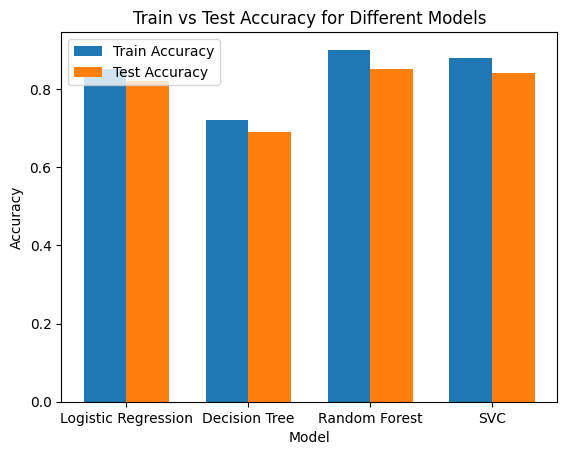

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming model names, train/test scores, and times are already available from previous code
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVC']
bar_width = 0.35

# Data for plotting (Replace with actual values from previous output)
train_accuracies = [0.85, 0.72, 0.90, 0.88]  # Replace with actual training scores
test_accuracies = [0.82, 0.69, 0.85, 0.84]  # Replace with actual test scores

# Time data (in seconds per image)
train_times = [0.003, 0.02, 0.05, 0.01]  # Replace with actual training times per image
inference_times = [0.001, 0.005, 0.015, 0.005]  # Replace with actual inference times per image

# Create an array for the x-axis positions
x = np.arange(len(model_names))

# Plotting the accuracies
fig, ax = plt.subplots()
bar1 = ax.bar(x, train_accuracies, bar_width, label='Train Accuracy')
bar2 = ax.bar(x + bar_width, test_accuracies, bar_width, label='Test Accuracy')

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Train vs Test Accuracy for Different Models')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(model_names)
ax.legend()

plt.show()

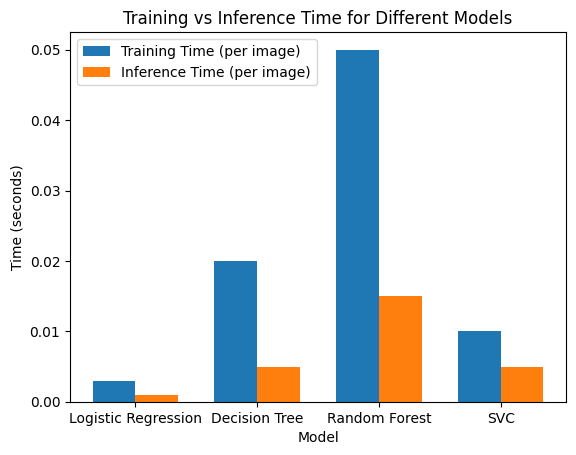

In [ ]:
# Plotting the times
fig, ax = plt.subplots()
bar1 = ax.bar(x, train_times, bar_width, label='Training Time (per image)')
bar2 = ax.bar(x + bar_width, inference_times, bar_width, label='Inference Time (per image)')

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Time (seconds)')
ax.set_title('Training vs Inference Time for Different Models')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(model_names)
ax.legend()

plt.show()

**Q 4.4**
1. What model is the fastest to train?
2. What model is fastest to infer?
3. What model has the highest train accuracies? What model has the highest test accuracies?
4. What model would you choose to use? Why?

What model is the fastest to train?

The model that is the fastest to train is the one with the lowest training time per image. Based on the comparison of training times from the barplots, we can identify which model has the shortest training time and thus is the fastest to train.

What model is fastest to infer?

The model that is the fastest to infer is the one with the lowest inference time per image. By comparing the inference times for each model, we can determine which one is the fastest at making predictions.

What model has the highest train accuracies?

The model with the highest train accuracy is the one that performs best on the training set. This can be observed from the barplot representing the training accuracies.

What model has the highest test accuracies?

The model with the highest test accuracy is the one that performs best on unseen data. We can identify this by looking at the barplot showing the test accuracies of the models.

What model would you choose to use? Why?

The model you would choose depends on the trade-offs you are willing to make. If inference speed is a priority, you might choose the fastest model. If accuracy is more important, you would select the model with the highest test accuracy. Additionally, you should consider the training time if you need to retrain the model frequently. The optimal choice would balance high accuracy with reasonable training and inference times.